Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

In [34]:

import pandas as pd
import numpy as np
import os.path
from nlpUtils import aardvark as aa 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

# Load the Data
First load the data from csv that was created at the end of the dataCleaningB notebook.


In [13]:
tweets_clean = pd.read_csv("archiveData/demoji_tweets_clean.csv", header=0, index_col=0)
print(tweets_clean.shape)
print(aa.term_check("❤️", tweets_clean))
print()
tweets_unlabeled = pd.read_csv("archiveData/demoji_tweets_unlabeled.csv", header=0, index_col=0)
print(tweets_unlabeled.shape)
print(aa.term_check("❤️", tweets_unlabeled))

(1211, 10)
('❤️', 0)

(200084, 5)
('❤️', 0)


# Look for imbalanced classes

In [ ]:
df = pd.DataFrame(np.array([['a'], ['a'], ['b']]), columns=['current_status'])
ax = sns.countplot(y="current_status", data=df)
plt.title('Distribution of  Configurations')
plt.xlabel('Number of Axles')

total = len(df['current_status'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

In [85]:
total_ct = len(tweets_clean['y_sent'])
neg_ct, neu_ct, pos_ct = 0, 0, 0
for i in tweets_clean['y_sent']: 
    if i == 0:
        neg_ct += 1
    if i == 1:
        neu_ct += 1
    if i == 2:
        pos_ct += 1

neg_perct = round((neg_ct/total_ct)*100, 2)
neu_perct = round((neu_ct/total_ct)*100, 2)
pos_perct = round((pos_ct/total_ct)*100, 2)
print(neg_perct)
print(neu_perct)
print(pos_perct)

60.45
21.06
18.5


''

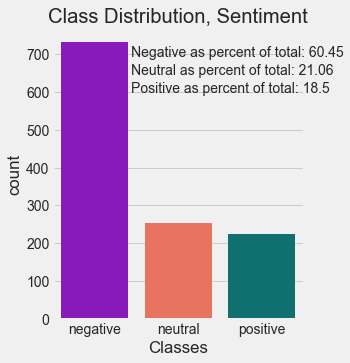

In [89]:
#plot class distribution
plt.figure(figsize=(4, 5))
plot_colors = ['darkviolet','tomato', 'teal']
sns.countplot(x=tweets_clean["y_sent"], palette=plot_colors).set_xticklabels(["negative", "neutral", "positive"])
plt.xlabel('Classes')
plt.title('Class Distribution, Sentiment')
plt.figtext(.35, .8, "Negative as percent of total: {}".format(neg_perct))
plt.figtext(.35, .75, "Neutral as percent of total: {}".format(neu_perct))
plt.figtext(.35, .7, "Positive as percent of total: {}".format(pos_perct))
;

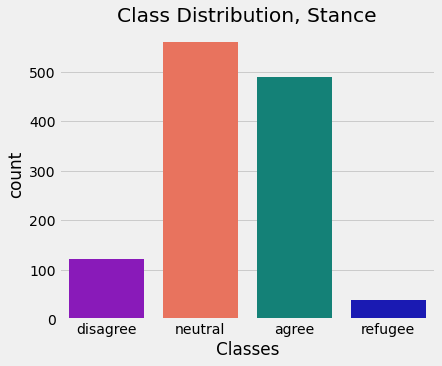

In [7]:
#plot class distribution
plt.figure(figsize=(6, 5))
plot_colors = ['darkviolet', 'tomato', 'xkcd:teal', 'mediumblue']
sns.countplot(x=tweets_clean["y_stance"], palette=plot_colors).set_xticklabels(["disagree", "neutral", "agree", "refugee"])
plt.xlabel('Classes')
plt.title('Class Distribution, Stance');

### Dealing with Imbalanced Data
So we have imbalanced classes in both categories: far more negative than positive/neutral tweets, for fewer disaggree than agree/neutral tweets. 

We will need to deal with that before using machine learning algorithms, or the models will simply learn to predict the majority class. This will be a problem we need to address in the __training__ and __validation__ sets for ML. 

IN ADDITION: remember that our evaluation metric will be __F1 and AUC__. Create a confusion matrix.

### Tweet Length

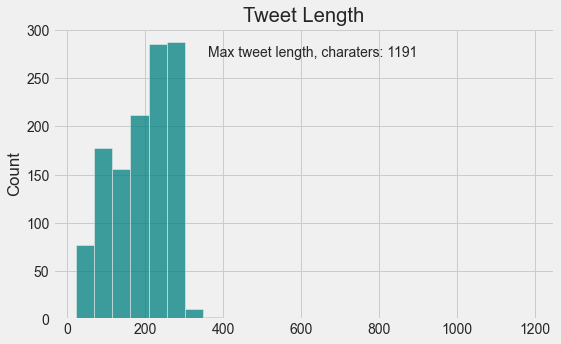

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot([len(s) for s in tweets_clean["ContentClean"]], bins=25, color="teal")
plt.figtext(.35, .8, "Max tweet length, charaters: {}".format(max([len(s) for s in tweets_clean["ContentClean"]])))
plt.title('Tweet Length')
# plt.style.use('ggplot') 
# plt.style.use('seaborn-white') 
plt.show()

In [15]:
print(max([len(s) for s in tweets_clean["ContentClean"]]))
print(max([len(s) for s in tweets_unlabeled["ContentClean"]]))

1191
1572


In [21]:
long_tweets = []
for i, tweet in enumerate(tweets_clean["ContentClean"]):
    if len(tweet) > 500:
        long_tweets.append(i)
long_tweets

[111]

In [22]:
tweets_clean["ContentClean"].iloc[111]

'Trump Slams Afghan Refugee Plan, Defends Travel Ban:United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::Un

Exchanging the emoji for a text code has created some very long tweets, if you count by character. Fortunately, I don't think we need to count by character. Both VADER and BERT deal at the word-level.

length of longest tweet: 60


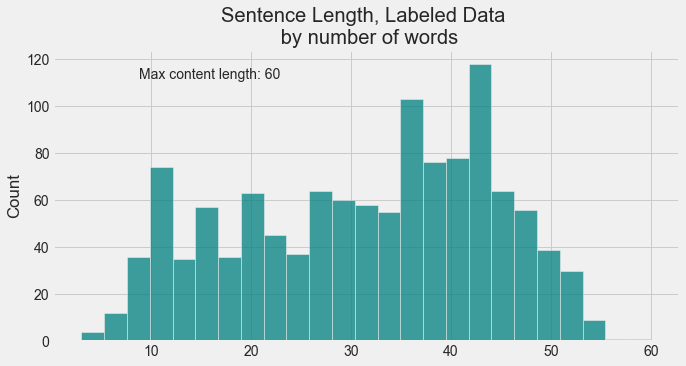

In [44]:
a = [len(i.split()) for i in tweets_clean["ContentClean"]]
max_a = (max(a))
ind_max_a = a.index(max_a)
print("length of longest tweet:", max_a)

plt.figure(figsize=(10, 5))
sns.histplot(a, bins=25, color="teal")
plt.title('Sentence Length, Labeled Data \n by number of words')
plt.figtext(.2, .8, "Max content length: {}".format(max(a)))
# plt.style.use('ggplot') 
# #plt.style.use('Solarize_Light2') 
# plt.style.use('seaborn-white') 
plt.show()

length of longest tweet: 63


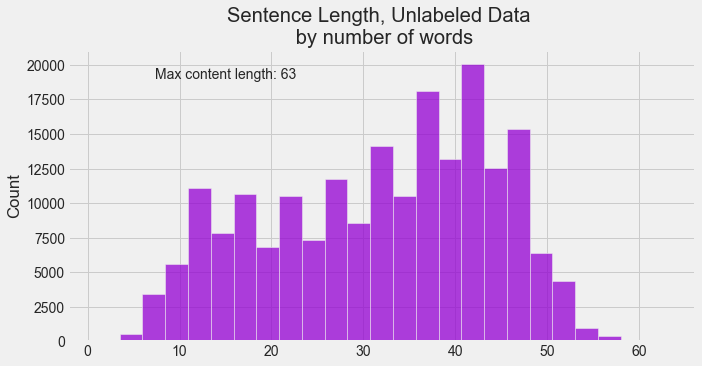

In [45]:
a = [len(i.split()) for i in tweets_unlabeled["ContentClean"]]
max_a = (max(a))
ind_max_a = a.index(max_a)
print("length of longest tweet:", max_a)

plt.figure(figsize=(10, 5))
sns.histplot(a, bins=25, color="darkviolet")
plt.title('Sentence Length, Unlabeled Data \n by number of words')
plt.figtext(.2, .8, "Max content length: {}".format(max(a)))
# plt.style.use('ggplot') 
# #plt.style.use('Solarize_Light2') 
# plt.style.use('seaborn-white') 
plt.show()

### PAUSE / UNPAUSE

In [46]:
# PAUSE
tweets_clean.to_csv(os.path.join('archiveData', "temp_tweets_clean.csv"))

# UNPAUSE
# tweets_clean = pd.read_csv(os.path.join('archiveData', "temp_tweets_clean.csv"), header=0, index_col=0)

# Split the Dataset

### Train/Test Split
First we are going to split out a testing set. 

We have mild to moderately imbalanced data. We are going to KEEP the imbalance in the testing set. That way we will eventually be testing how the models work on data that looks like real-world data. That is important because, in the end, the intention is to apply the best model to the full dataset for real-world knowledge extraction. 

In [48]:
print(list(tweets_clean.columns))  

['id_stable', 'Date', 'Content', 'ContentClean', 'Labels', 'label_sent', 'y_sent', 'label_stance', 'y_stance', 'Flag']


In [49]:
# Create a df with the relevant X data
x_cols = ['id_stable', 'Date', 'ContentClean']
x_data = tweets_clean[x_cols]
print(x_data.shape)
x_data.head()

(1211, 3)


,id_stable,Date,ContentClean
0,170314,2021-08-15 17:53:06+00:00,Per a White House official: Biden and Harris m...
1,192623,2021-06-02 17:31:25+00:00,Afghan Refugee kid educated in Iran wins this ...
2,106982,2021-08-28 07:53:12+00:00,Not only did Trump stop processing asylum & re...
3,31609,2021-12-23 18:00:41+00:00,An Afghan refugee demands the US not forget he...
4,152666,2021-08-17 20:06:41+00:00,One moment you hate refugees and the next you ...


In [50]:
# Create a df with the relevant y data
y_cols = ['id_stable', 'Date', 'label_sent', 'y_sent', 'label_stance', 'y_stance']
y_sent = tweets_clean[y_cols]
print(y_sent.shape)
y_sent.head()

(1211, 6)


,id_stable,Date,label_sent,y_sent,label_stance,y_stance
0,170314,2021-08-15 17:53:06+00:00,neutral,1,neutral,1
1,192623,2021-06-02 17:31:25+00:00,happy,2,na,1
2,106982,2021-08-28 07:53:12+00:00,disgust,0,neutral,1
3,31609,2021-12-23 18:00:41+00:00,plea - disgust,0,refugee - agree,3
4,152666,2021-08-17 20:06:41+00:00,hopeful,2,agree,2


In [51]:
# create the train and test, X and y sets,  
x_train, x_test, y_train_sent, y_test_sent = train_test_split(x_data, y_sent, test_size = 0.15, random_state = 1018, stratify = y_sent.y_sent.values)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train_sent:", y_train_sent.shape)
print("y_test_sent:", y_test_sent.shape)


x_train: (1029, 3)
x_test: (182, 3)
y_train_sent: (1029, 6)
y_test_sent: (182, 6)


In [ ]:
print(y_train["y_bert"].value_counts())
print(y_val["y_bert"].value_counts())

plt.figure(figsize=(4, 12))

fig, ax =plt.subplots(1,2)
sns.countplot(x=y_train["y_bert"], palette=my_plot_colors, ax=ax[0]).set_xticklabels(["neg", "neutral", "pos"])
ax[0].set_title('Class Distribution, \n training data')

sns.countplot(x=y_val["y_bert"], palette=my_plot_colors, ax=ax[1], ).set_xticklabels(["neg", "neutral", "pos"])
ax[1].set_title('Class Distribution, \n validation data')

fig.show()

In [91]:
test_ct = len(y_test_sent['y_sent'])
neg_ct_test, neu_ct_test, pos_ct_test = 0, 0, 0
for i in y_test_sent['y_sent']: 
    if i == 0:
        neg_ct_test += 1
    if i == 1:
        neu_ct_test += 1
    if i == 2:
        pos_ct_test += 1

neg_perct_test = round((neg_ct_test/test_ct)*100, 2)
neu_perct_test = round((neu_ct_test/test_ct)*100, 2)
pos_perct_test = round((pos_ct_test/test_ct)*100, 2)
print(neg_perct_test)
print(neu_perct_test)
print(pos_perct_test)

60.44
20.88
18.68


Text(0.7, 0.7, 'Positive: 18.68 %')

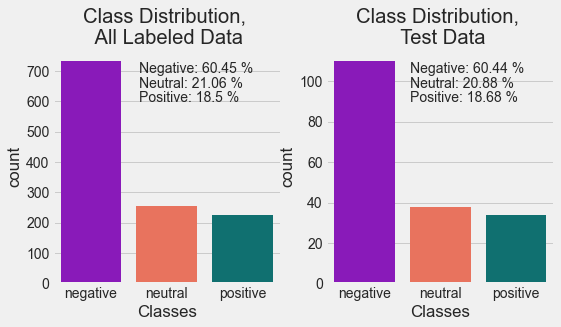

In [121]:
# Check that the test set distribution is similar to the full labeled data set.
#plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_colors = ['darkviolet','tomato', 'teal']

sns.countplot(x=tweets_clean["y_sent"], palette=plot_colors, ax=ax[0]).set_xticklabels(["negative", "neutral", "positive"])
ax[0].set_xlabel('Classes')
ax[0].set_title('Class Distribution, \n All Labeled Data');

sns.countplot(x=y_test_sent["y_sent"], palette=plot_colors, ax=ax[1]).set_xticklabels(["negative", "neutral", "positive"])
ax[1].set_xlabel('Classes')
ax[1].set_title('Class Distribution, \n Test Data');

plt.figtext(.23, .8, "Negative: {} %".format(neg_perct))
plt.figtext(.23, .75, "Neutral: {} %".format(neu_perct))
plt.figtext(.23, .7, "Positive: {} %".format(pos_perct))

plt.figtext(.7, .8, "Negative: {} %".format(neg_perct_test))
plt.figtext(.7, .75, "Neutral: {} %".format(neu_perct_test))
plt.figtext(.7, .7, "Positive: {} %".format(pos_perct_test))

The data distribution in the test set looks very good. Save it to dataBalancedSets.

In [123]:
x_test.to_csv("dataBalancedSets/x_test.csv")
y_test_sent.to_csv("dataBalancedSets/y_test_sent.csv")

Moving on.

### Train/Validation Split

We have mild to moderately imblanced data. This is not a problem for VADER but it MIGHT be a problem for BERT. 

In order to keep the preprocessing as similar as possible betweent the two models, if we are going to balance the data for one, we should balance the data for both.

So, we are going to try a few different methods of the following possibilities:
1. Just use unbalanced data for both
2. Undersampling
3. Undersampling & Oversampling
4. Undersampling & SMOTE
5. Undersampling & Back Translation

We will create one train/val dataset using each method and put them in the dataBalancedSets folder.

### CHECK THIS!!! _______________
stratify: in train_test_split: StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

This is an option to try if I get bad results with downsampling.

### Train/Test split

In [20]:
x_train, x_val, y_train_sent, y_val_sent = train_test_split(x_data, y_sent, test_size = 0.3, random_state = 1018, stratify = y_sent.y_sent.values)
print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("y_train_sent:", y_train_sent.shape)
print("y_val_sent:", y_val_sent.shape)

# x_train, x_val, y_train_sent, y_val_sent = train_test_split(x_data, y_sent, test_size = 0.2, random_state = 1018, stratify = tweets_clean.label.values)


x_train: (742, 15)
x_val: (319, 15)
y_train_sent: (742, 2)
y_val_sent: (319, 2)


# Save Clean, Split Files
For use with dictionary models: VADER, TextBlob

In [21]:
x_train.to_csv(os.path.join('data', "x_train.csv"))
x_val.to_csv(os.path.join('data', "x_val.csv"))
y_train_sent.to_csv(os.path.join('data', "y_train_sent.csv"))
y_val_sent.to_csv(os.path.join('data', "y_val_sent.csv"))

But I'm also going to need access to the complete sets, sooo...

In [22]:
data_unlabeled = pd.read_csv(os.path.join('data', "data_unlabeled2_05_09.csv"), header=0, index_col=0)
print(data_unlabeled.shape)
print(list(data_unlabeled.columns))

(200084, 16)
['id_stable', 'Date', 'Content', 'ContentClean', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Flag']


In [ ]:
bad_cols = ['n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags']
data_unlabeled.drop(bad_cols, axis=1, inplace=True)
aa.last_clean (data_unlabeled, text_col="ContentClean", indx_warning=False, verby=True)


In [24]:
tweets_clean.to_csv(os.path.join('data', "all_labeled_tweets.csv"))
data_unlabeled.to_csv(os.path.join('data', "all_unlabeled_tweets.csv"))